In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
import seaborn as sns
import warnings
import datetime as dt
from datetime import timedelta
warnings.filterwarnings('ignore')

sns.set()

## 5B.1 Feature Selection

In [2]:
%store -r feature_candidates1

In [3]:
feature_candidates1 = feature_candidates1[
['resale_price', 'resale_year', 'floor_area_sqm',
 'sarima_forecast', 'lag1','lag2', 'lag3', 'trend', 'lease_commence_year', 'resale_month',
 'resale_quarter', 'storey_range','flat_type','town', 'flat_model', 'resale_date']]
# rearrange columns


In [4]:
# create a combination of feature
# for the second model, we may incorporate SARIMA components, such as trend, forecast, and lagged values into the model
# After some trial and error, incorporating third lagged values and trend makes the simplest model without sacrificing metrics
# While resale_year and resale_month can be removed as their role has been replaced by SARIMA components

feat = feature_candidates1.drop(['resale_quarter','resale_month', 'resale_year', 'lag1', 'lag2', 'sarima_forecast'], axis = 1)
feat.shape

# Here we have 10 variables, including the target

(152529, 10)

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [6]:
target = feat.iloc[:, 0]
feat_num = feat.iloc[:, 1:7]
feat_cat = feat.iloc[:,7:]
scaled_feat_num = scaler.fit_transform(feat_num)
scaled_feat_num = pd.DataFrame(scaled_feat_num, columns = feat_num.columns, index = feat_num.index)

In [7]:
new_feat = pd.concat([target, scaled_feat_num, feat_cat], axis = 1)
new_feat.head()

,resale_price,floor_area_sqm,lag3,trend,lease_commence_year,storey_range,flat_type,town,flat_model,resale_date
7925,233000.0,-2.180209,-0.703406,-0.871266,-0.710398,-0.130200,-2.323434,ANG MO KIO,IMPROVED,2017-06-01
7926,250000.0,-2.221785,-0.703406,-0.871266,-1.283978,-0.130200,-2.323434,ANG MO KIO,IMPROVED,2017-06-01
7927,235000.0,-1.265550,-0.703406,-0.871266,-1.427373,-0.130200,-1.236228,ANG MO KIO,NEW GENERATION,2017-06-01
7928,260000.0,-1.223975,-0.703406,-0.871266,-1.140583,-0.130200,-1.236228,ANG MO KIO,NEW GENERATION,2017-06-01
7929,260000.0,-1.223975,-0.703406,-0.871266,-1.068886,-1.135196,-1.236228,ANG MO KIO,NEW GENERATION,2017-06-01


## 5B.2 Model Building

In [8]:
dummies = pd.get_dummies(new_feat, drop_first= True, prefix_sep= '-') #create dummy variables
dummies.head()

# After creating dummy variables, the variables becomes 53, including the target
# Much simpler than those of baseline model

,resale_price,floor_area_sqm,lag3,trend,lease_commence_year,storey_range,flat_type,resale_date,town-BEDOK,town-BISHAN,...,flat_model-MULTI GENERATION,flat_model-NEW GENERATION,flat_model-PREMIUM APARTMENT,flat_model-PREMIUM APARTMENT LOFT,flat_model-PREMIUM MAISONETTE,flat_model-SIMPLIFIED,flat_model-STANDARD,flat_model-TERRACE,flat_model-TYPE S1,flat_model-TYPE S2
7925,233000.0,-2.180209,-0.703406,-0.871266,-0.710398,-0.130200,-2.323434,2017-06-01,0,0,...,0,0,0,0,0,0,0,0,0,0
7926,250000.0,-2.221785,-0.703406,-0.871266,-1.283978,-0.130200,-2.323434,2017-06-01,0,0,...,0,0,0,0,0,0,0,0,0,0
7927,235000.0,-1.265550,-0.703406,-0.871266,-1.427373,-0.130200,-1.236228,2017-06-01,0,0,...,0,1,0,0,0,0,0,0,0,0
7928,260000.0,-1.223975,-0.703406,-0.871266,-1.140583,-0.130200,-1.236228,2017-06-01,0,0,...,0,1,0,0,0,0,0,0,0,0
7929,260000.0,-1.223975,-0.703406,-0.871266,-1.068886,-1.135196,-1.236228,2017-06-01,0,0,...,0,1,0,0,0,0,0,0,0,0


In [9]:
feature_candidates1.groupby('resale_year').size().cumsum() / len(feature_candidates1) * 100

# we use the same train-test split as that in baseline model

resale_year
2017      8.133535
2018     22.257407
2019     36.786447
2020     52.060264
2021     71.101889
2022     88.600201
2023    100.000000
dtype: float64

In [10]:
# Here I pick Aug 2022 as the limit of train dataset (1 year before the last date)
# Which is close to 80:20 split

filter_year = dummies['resale_date'] <= 'Aug 2022'
dummies = dummies.drop(['resale_date'], axis = 1) #drop resale_date because it is unusable in the model
train = dummies[filter_year] # training dataset
test = dummies[~filter_year] # testing dataset

In [11]:
len(test)/len(train)

0.20816006463417533

In [12]:
X_train = train.iloc[:, 1:] # training predictors
X_test = test.iloc[:, 1:] # testing predictors
y_train = train.iloc[:, 0] # training target
y_test = test.iloc[:, 0] # testing target

In [13]:
from sklearn.linear_model import RidgeCV

In [14]:
# Create a list of alpha values to consider
alphas = [0.01, 0.1, 1, 10, 100]

# Initialize RidgeCV with cross-validation
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)

# Fit the RidgeCV model to your training data
ridge_cv.fit(X_train, y_train)

# Determine the best alpha value from cross-validation
best_alpha = ridge_cv.alpha_

print("Best alpha:", best_alpha)


Best alpha: 0.01


In [15]:
from sklearn.linear_model import Ridge

RidgeRegression = Ridge(alpha = 0.01).fit(X_train, y_train)

In [16]:
y_train_pred = RidgeRegression.predict(X_train)
y_test_pred = RidgeRegression.predict(X_test)
y_pred = np.hstack([y_train_pred, y_test_pred])

In [17]:
y_pred_df = pd.DataFrame(y_pred, index = new_feat.index)
y_pred_df = pd.concat([new_feat['resale_date'], y_pred_df], axis = 1)
y_train_pred_df = y_pred_df[filter_year]
y_test_pred_df = y_pred_df[~filter_year]

## 5B.3 Visual Evaluation

In [18]:
model_coef = pd.DataFrame(RidgeRegression.coef_, index = X_train.columns, columns= ['Coefficient'])
model_coef_num = model_coef.iloc[:6].sort_values(by = 'Coefficient', ascending = False)
model_coef_cat = model_coef.iloc[6:]
model_coef_town = model_coef_cat.iloc[:25].sort_values(by = 'Coefficient', ascending = False)
model_coef_model = model_coef_cat.iloc[25:].sort_values(by = 'Coefficient', ascending = False)

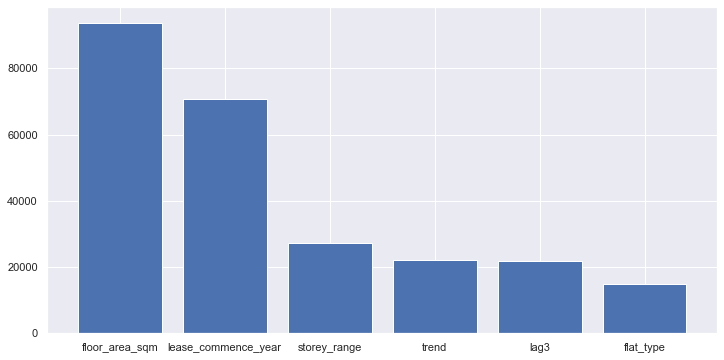

In [19]:
plt.figure(figsize=[12,6])
plt.bar(model_coef_num.index, model_coef_num['Coefficient'])
plt.xticks(rotation = 0);

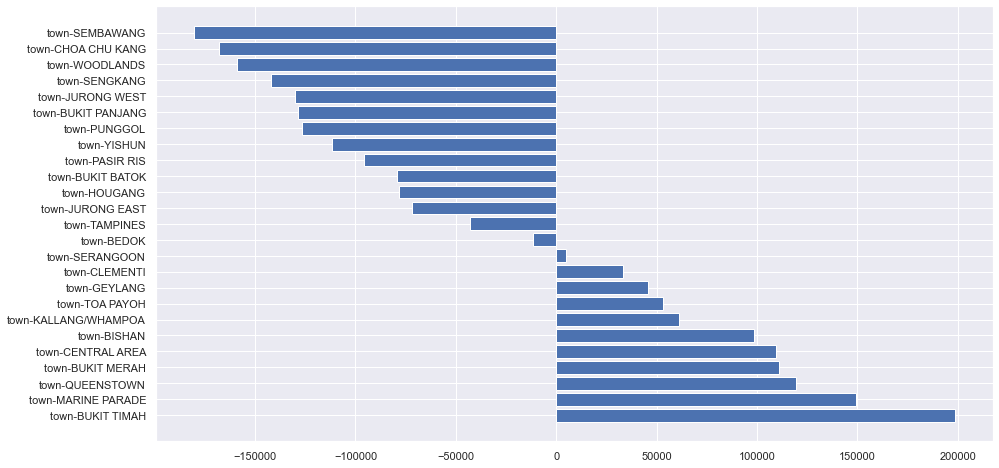

In [20]:
plt.figure(figsize=[15,8])
plt.barh(model_coef_town.index, model_coef_town['Coefficient'])
plt.xticks(rotation = 0);

# Note that the reference category for this feature is 'ANG MO KIO'

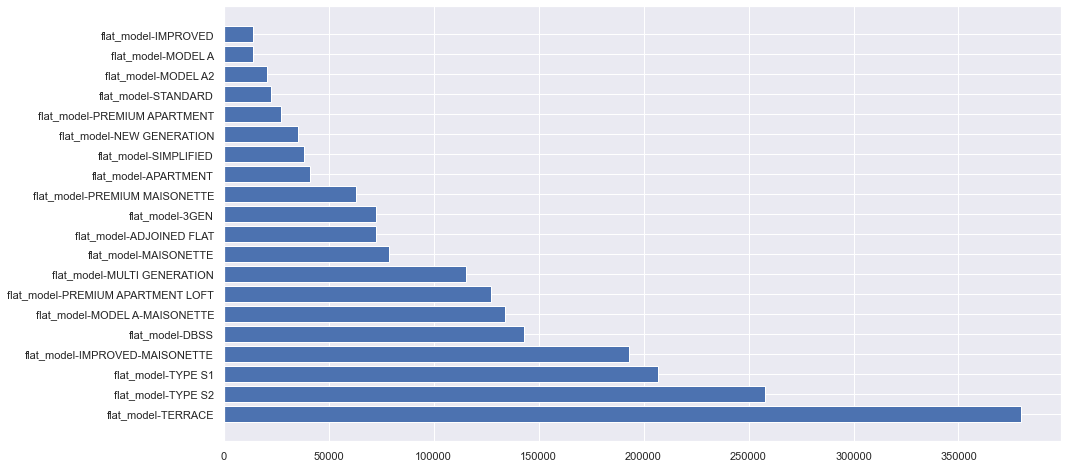

In [21]:
plt.figure(figsize=[15,8])
plt.barh(model_coef_model.index, model_coef_model['Coefficient'])
plt.xticks(rotation = 0);

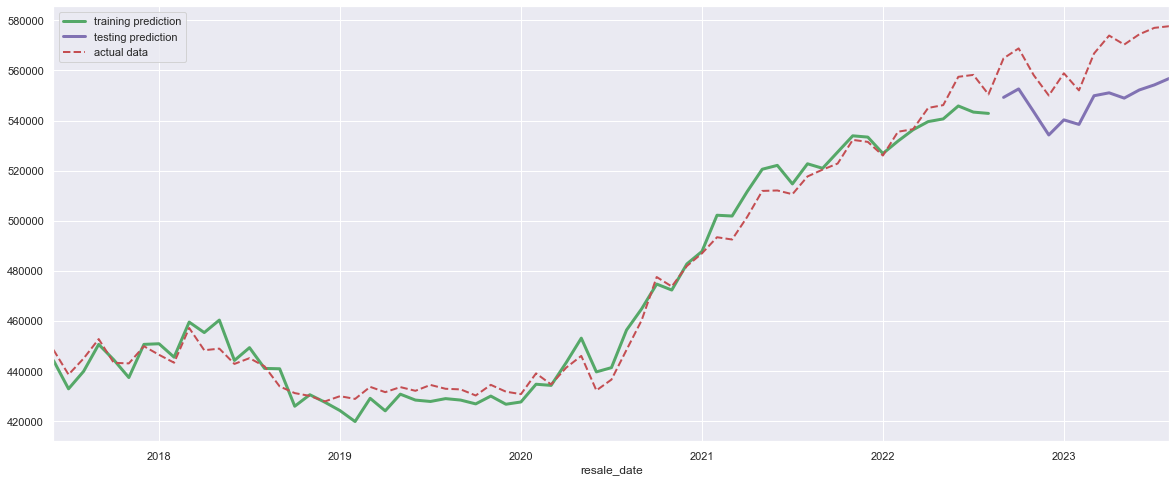

In [22]:
# Compare the training and testing predictions with actual dataset

plt.figure(figsize=[20,8])
y_train_pred_df.groupby('resale_date')[0].mean().plot(color = 'g', label = 'training prediction', linewidth = 3)
y_test_pred_df.groupby('resale_date')[0].mean().plot(color = 'm', label = 'testing prediction', linewidth = 3)
new_feat.groupby('resale_date')['resale_price'].mean().plot(color = 'r', label = 'actual data', linewidth = 2, linestyle = '--')
plt.legend();


In [23]:
train_residual = y_train_pred - y_train
test_residual = y_test_pred - y_test

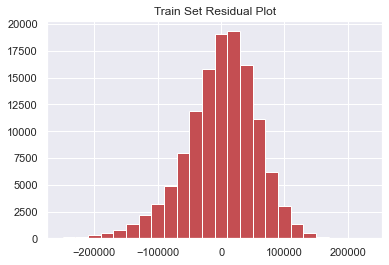

In [24]:
bins = np.arange(-250000, 250000, 20000)
plt.hist(train_residual, color = 'r', bins = bins)
plt.title('Train Set Residual Plot')
plt.show();

In [25]:
train_residual.mean()

#close to zero

1.6910554435949256e-11

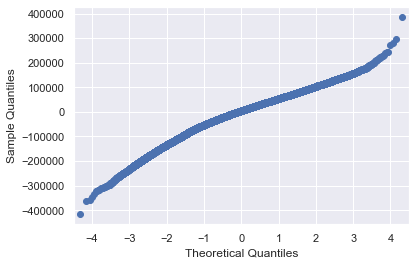

In [26]:
import statsmodels.api as sm
sm.qqplot(train_residual);

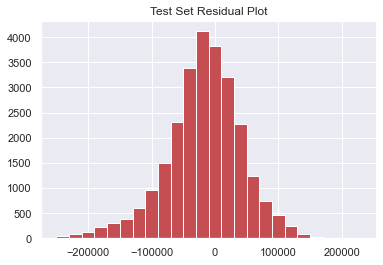

In [27]:
plt.hist(test_residual, color = 'r', bins = bins)
plt.title('Test Set Residual Plot')
plt.show();

In [28]:
test_residual.mean()

# Still far from zero, but much better than that of baseline model

-18453.124587645194

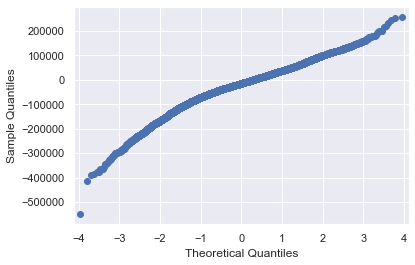

In [29]:
sm.qqplot(test_residual);

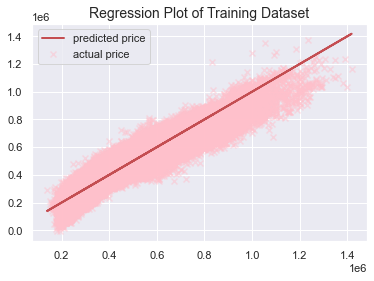

In [30]:
sns.set()
plt.scatter(y_train, y_train_pred, marker = 'x', color = 'pink', alpha = 0.5, label = 'actual price')
plt.plot(y_train, y_train, linewidth = 2, label = 'predicted price', color = 'r')
plt.title('Regression Plot of Training Dataset', fontsize = 14)
plt.legend()
plt.show()

# based on the plot below, we can observe that the values are scattered relatively evenly around the regression line
# it looks homoscedastic enough

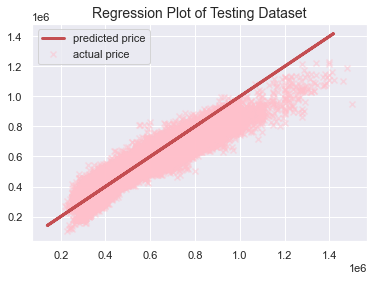

In [31]:
plt.scatter(y_test, y_test_pred, marker = 'x', alpha = 0.5, color = 'pink', label = 'actual price')
plt.plot(y_train, y_train, color = 'r', linewidth = 3, label = 'predicted price')
plt.title('Regression Plot of Testing Dataset', fontsize = 14)
plt.legend()
plt.show()

In [32]:
## 5B.4 Metrics Evaluation

In [33]:
from sklearn.metrics import r2_score

r_squared = r2_score(target, y_pred)

print(f'R-Squared = {r_squared*100:.3f} %')

R-Squared = 87.865 %


In [34]:
from sklearn.metrics import mean_absolute_error as MAE

test_MAE = MAE(y_test, y_test_pred)
train_MAE = MAE(y_train, y_train_pred)
delta_MAE = (test_MAE - train_MAE)/train_MAE*100

In [35]:
mean_resale_price = feature_candidates1.groupby('resale_date')['resale_price'].mean()

In [36]:
# We can see that in this model, the MAE of testing dataset dropped dramatically compared to that of baseline
# from 62002 to 47185

print(f'Mean of Actual Monthly Resale Price: ', f'SGD {mean_resale_price.mean():.2f}')
print(f'MAE of test dataset: ', f'{test_MAE:.2f}')
print(f'MAE of train dataset: ', f'{train_MAE:.2f}')
print(f'MAE change: ', f'{delta_MAE:.2f}'+'%')

Mean of Actual Monthly Resale Price:  SGD 483783.74
MAE of test dataset:  47998.72
MAE of train dataset:  44328.39
MAE change:  8.28%


In [37]:
from sklearn.metrics import mean_squared_error as MSE

test_MSE = MSE(y_test, y_test_pred)
train_MSE = MSE(y_train, y_train_pred)
delta_MSE = (test_MSE - train_MSE)/train_MSE*100

In [38]:
print(f'MSE of test dataset: ', f'{test_MSE:.3f}')
print(f'MSE of train dataset: ', f'{train_MSE:.3f}')
print(f'MSE change: ', f'{delta_MSE:.2f}'+'%')

MSE of test dataset:  4211646362.852
MSE of train dataset:  3317426248.005
MSE change:  26.96%
